# Exploratory Data Analysis

This notebook performs exploratory analysis of the Metacritic film dataset to understand data structure and quality.

**Datasets:**
- Sales data (box office, budget, opening weekend)
- Metacritic metadata (genres, ratings, release dates)
- Expert reviews (critical reception, sentiment)

---
## Setup & Configuration

In [ ]:
# Benita
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings

warnings.filterwarnings('ignore')

---
### Load & Initial Inspection

In [ ]:
# Benita
# CONFIGURATION
CACHE_FOLDER = r"C:\Users\benit\Documents\ai4business"
USE_CACHE = True

FILE_PATHS = {
    "sales_df": r"sales.xlsx",
    "meta_df": r"metaClean43Brightspace.xlsx",
    "expert_df": r"ExpertReviewsClean43LIWC (1).xlsx"
}

# CACHE MANAGEMENT FUNCTIONS
def create_cache_folder():
    """Create cache folder if it doesn't exist on the file system"""
    if not os.path.exists(CACHE_FOLDER):
        os.makedirs(CACHE_FOLDER)
        print(f"Created cache folder: {CACHE_FOLDER}")

def get_cache_path(filename):
    """Generate full file path for cached pickle file"""
    return os.path.join(CACHE_FOLDER, f"{filename}.pkl")

def save_to_cache(data, filename):
    """Save dataframe or data object to cache file using pickle serialization"""
    try:
        create_cache_folder()
        cache_path = get_cache_path(filename)
        with open(cache_path, 'wb') as f:
            pickle.dump(data, f)
        print(f" Cached {filename}")
    except Exception as e:
        print(f" Could not cache {filename}: {e}")

def load_from_cache(filename):
    """Load dataframe or data object from cache file if it exists"""
    try:
        cache_path = get_cache_path(filename)
        if os.path.exists(cache_path):
            with open(cache_path, 'rb') as f:
                data = pickle.load(f)
            print(f" Loaded {filename} from cache")
            return data
        else:
            return None
    except Exception as e:
        print(f" Could not load {filename} from cache: {e}")
        return None


In [ ]:
# Benita/Ariana
# DATA LOADING
def load_single_dataset(dataset_name, file_path):
    """Load a single dataset from cache or Excel file"""
    print(f"\nLoading {dataset_name}...")
    if USE_CACHE:
        cached_data = load_from_cache(dataset_name)
        if cached_data is not None:
            return cached_data

    try:
        print(f"  Loading from Excel: {file_path}")
        data = pd.read_excel(file_path)
        if USE_CACHE:
            save_to_cache(data, dataset_name)
        print(f"  Loaded {dataset_name} from Excel ({len(data)} rows)")
        return data
    except FileNotFoundError as e:
        print(f"  Error loading {dataset_name}: {e}")
        print("  Please check file path")
        raise

def load_all_datasets():
    """Load sales_df , meta_df , and Expert_df datasets"""
    print("Loading datasets...")
    datasets = {}
    for dataset_name, file_path in FILE_PATHS.items():
        datasets[dataset_name] = load_single_dataset(dataset_name, file_path)

    print("\nAll files loaded successfully!")
    for name, df in datasets.items():
        print(f"\n{name} columns:")
        print(df.columns.tolist())
        print(f"Shape: {df.shape}")
    return datasets


# TITLE / NAME CLEANING HELPER
def clean_movie_name(text):
    """
    Aggressive cleaning for generating stable keys / IDs.
    - Lowercase
    - Strip URL path / punctuation
    - Remove brackets & years
    - Collapse spaces
    """
    if pd.isna(text) or text is None:
        return ""
    name = str(text).lower().strip().rstrip("/")

    # If it's a URL, just use the last segment after '/'
    name = name.rsplit("/", 1)[-1]

    # Replace dashes/underscores with spaces
    name = name.replace("-", " ").replace("_", " ")

    # Remove bracketed content () or []
    name = re.sub(r"\([^)]*\)|\[[^\]]*\]", "", name)

    # Remove non-alphanumeric (keep spaces)
    name = re.sub(r"[^a-z0-9 ]", "", name)

    # Remove trailing years like "1999" or "2016"
    name = re.sub(r"[\(\[]\s*(?:19|20)\d{2}[^)\]]*\s*[\)\]]\s*$|(?:19|20)\d{2}\s*$", "", name)

    # Collapse multiple spaces
    name = re.sub(r"\s+", " ", name).strip()

    return name

# CREATE cleaned_title FOR EACH DATASET
def create_cleaned_title_for_sales(sales_df):
    """
    Ensure sales_df has a 'cleaned_title' column based on the best available source:
    - Prefer 'cleaned_title' if it already exists
    - Else prefer 'url'
    - Else fall back to 'Title'/'title'
    - Else mark as empty
    """
    if "cleaned_title" in sales_df.columns:
        print("sales_df: 'cleaned_title' already exists, reusing.")
        return

    if "url" in sales_df.columns:
        source_col = "url"
        print("sales_df: creating 'cleaned_title' from 'url'")
    elif "Title" in sales_df.columns:
        source_col = "Title"
        print("sales_df: creating 'cleaned_title' from 'Title'")
    elif "title" in sales_df.columns:
        source_col = "title"
        print("sales_df: creating 'cleaned_title' from 'title'")
    else:
        print("sales_df: no suitable title-like column found, setting empty cleaned_title")
        sales_df["cleaned_title"] = ""
        return

    sales_df["cleaned_title"] = sales_df[source_col].apply(clean_movie_name)

def create_cleaned_title_for_meta(meta_df):
    """
    Ensure meta_file_clean has a 'cleaned_title' column based on the best available source:
    - Prefer 'cleaned_title' if it already exists
    - Else prefer 'Title'/'title'
    - Else fall back to 'url'
    - Else mark as empty
    """
    if "cleaned_title" in meta_df.columns:
        print("meta_file_clean: 'cleaned_title' already exists, reusing.")
        return

    if "Title" in meta_df.columns:
        source_col = "Title"
        print("meta_df: creating 'cleaned_title' from 'Title'")
    elif "title" in meta_df.columns:
        source_col = "title"
        print("meta_df: creating 'cleaned_title' from 'title'")
    elif "url" in meta_df.columns:
        source_col = "url"
        print("meta_df: creating 'cleaned_title' from 'url'")
    else:
        print("meta_df: no suitable title-like column found, setting empty cleaned_title")
        meta_df["cleaned_title"] = ""
        return

    meta_df["cleaned_title"] = meta_df[source_col].apply(clean_movie_name)


def create_cleaned_title_for_expert(expert_df):
    """
    Ensure expert_df has a 'cleaned_title' column based on the best available source:
    - Prefer 'cleaned_title' if it already exists
    - Else prefer 'Title'/'title'
    - Else fall back to 'url'
    - Else mark as empty
    """
    if "cleaned_title" in expert_df.columns:
        print("expert_df: 'cleaned_title' already exists, reusing.")
        return

    if "Title" in expert_df.columns:
        source_col = "Title"
        print("expert_df: creating 'cleaned_title' from 'Title'")
    elif "title" in expert_df.columns:
        source_col = "title"
        print("expert_df: creating 'cleaned_title' from 'title'")
    elif "url" in expert_df.columns:
        source_col = "url"
        print("expert_df: creating 'cleaned_title' from 'url'")
    else:
        print("expert_df: no suitable title-like column found, setting empty cleaned_title")
        expert_df["cleaned_title"] = ""
        return

    expert_df["cleaned_title"] = expert_df[source_col].apply(clean_movie_name)


# MOVIE ID GENERATION BASED ON cleaned_title
def create_movie_ids(datasets_dict):
    """
    Create stable movie_id values based ONLY on a single standardized 'cleaned_title'
    shared between meta_file_clean and sales_df.

    - cleaned_title is the canonical movie name (lowercase, stripped)
    - movie_id is generated from unique cleaned_title across both datasets
    - Any raw 'Title' / 'title' columns are left alone here but can be dropped later
    """
    sales_df = datasets_dict["sales_df"]
    meta_df = datasets_dict["meta_df"]
    expert_df = datasets_dict["expert_df"]

    # Build cleaned_title in both datasets
    create_cleaned_title_for_sales(sales_df)
    create_cleaned_title_for_meta(meta_df)
    create_cleaned_title_for_expert(expert_df)

    # Collect all cleaned titles from both
    all_cleaned = pd.concat([
        sales_df["cleaned_title"].dropna(),
        meta_df["cleaned_title"].dropna(),
        expert_df["cleaned_title"].dropna()
    ]).unique()

    # Filter out empty strings
    all_cleaned = [t for t in all_cleaned if isinstance(t, str) and t.strip() != ""]

    # Create movie_key dimension: movie_id ↔ cleaned_title
    movie_key = pd.DataFrame([
        {
            "movie_id": idx + 1,
            "cleaned_title": cleaned
        }
        for idx, cleaned in enumerate(sorted(all_cleaned))
    ])

    print(f"\nCreated movie_key with {len(movie_key)} unique movies")

    # Map cleaned_title -> movie_id
    name_to_id = dict(zip(movie_key["cleaned_title"], movie_key["movie_id"]))

    # Attach movie_id back to dataframes
    sales_df["movie_id"] = sales_df["cleaned_title"].map(name_to_id).astype("Int64")
    meta_df["movie_id"] = meta_df["cleaned_title"].map(name_to_id).astype("Int64")
    expert_df["movie_id"] = expert_df["cleaned_title"].map(name_to_id).astype("Int64")

    # drop any raw Title columns
    for df_name, df in [("sales_df", sales_df), ("meta_file_clean", meta_df), ("expert_df", expert_df)]:
        raw_title_cols = [c for c in df.columns if c.lower() == "title"]
        if raw_title_cols:
            df.drop(columns=raw_title_cols, inplace=True)
            print(f"{df_name}: dropped raw title columns {raw_title_cols}")

    return movie_key, sales_df, meta_df, expert_df


# MERGE META + SALES ON movie_id (KEEP ONLY cleaned_title)
def merge_datasets(meta_df, sales_df, expert_df):
    # 1. Merge meta and sales first
    meta_sales = meta_df.merge(
        sales_df,
        on="movie_id",
        how="inner",
        suffixes=("_meta", "_sales")
    )

    # 2. Merge the result with the expert dataset
    merged = meta_sales.merge(
        expert_df,
        on="movie_id",
        how="inner",
        # Use a suffix for the new expert columns if there are name collisions
        suffixes=("", "_expert") 
    )
    print(f"\nMerged datasets on movie_id: {merged.shape[0]} rows")

    # unify cleaned_title
    if "cleaned_title_meta" in merged.columns and "cleaned_title_sales" in merged.columns:
        merged["cleaned_title"] = merged["cleaned_title_meta"]
        merged.drop(columns=["cleaned_title_meta", "cleaned_title_sales"], inplace=True)
        print("Merged: unified 'cleaned_title' column.")

    # Drop rows where movie_id was not assigned
    before = merged.shape[0]
    merged = merged[merged["movie_id"].notna()].copy()
    after = merged.shape[0]
    print(f"Dropped {before - after} rows due to missing movie_id")

    return merged



# Run Above Funcitons
if __name__ == "__main__":
    # 1) Load datasets
    datasets = load_all_datasets()
    sales_df = datasets["sales_df"]
    meta_df = datasets["meta_df"]
    expert_df = datasets["expert_df"]

    # 2) Create standardized cleaned_title + movie_id
    movie_key, sales_df, meta_df, expert_df = create_movie_ids(datasets)

    # 3) Merge on movie_id with a single cleaned_title column
    merged_df = merge_datasets(meta_df, sales_df, expert_df)

    # 4) Quick sanity checks
    print("\n=== merged_df HEAD (movie_id, cleaned_title) ===")
    print(merged_df[["movie_id", "cleaned_title"]].head())

    print("\n=== movie_key HEAD ===")
    print(movie_key.head())

Loading datasets...

Loading sales_df...
 Loaded sales_df from cache

Loading meta_df...
 Loaded meta_df from cache

Loading expert_df...
 Loaded expert_df from cache

All files loaded successfully!

sales_df columns:
['year', 'release_date', 'title', 'genre', 'international_box_office', 'domestic_box_office', 'worldwide_box_office', 'production_budget', 'Unnamed: 8', 'opening_weekend', 'theatre_count', 'avg run per theatre', 'runtime', 'keywords', 'creative_type', 'url']
Shape: (30612, 16)

meta_df columns:
['url', 'title', 'studio', 'rating', 'runtime', 'cast', 'director', 'genre', 'summary', 'awards', 'metascore', 'userscore', 'RelDate']
Shape: (11364, 13)

expert_df columns:
['url', 'idvscore', 'reviewer', 'dateP', 'Rev']
Shape: (238973, 5)
sales_df: creating 'cleaned_title' from 'url'
meta_df: creating 'cleaned_title' from 'title'
expert_df: creating 'cleaned_title' from 'url'

Created movie_key with 34395 unique movies
sales_df: dropped raw title columns ['title']
meta_file_clean

In [ ]:
# Benita
print("First 10 rows of film data:")
df.head(10)

First 10 rows of film data:


,url_meta,studio,rating,runtime_meta,cast,director,genre_meta,summary,awards,metascore,...,url,idvscore,reviewer,dateP,Rev,cleaned_title,date_dt,release_year,release_quarter,release_month
0,https://www.metacritic.com/movie/!women-art-re...,Hotwire Productions,| Not Rated,83.0,NaN,Lynn Hershman-Leeson,Documentary,NaN,NaN,70,...,https://www.metacritic.com/movie/!women-art-re...,90.0,'Rachel Saltz',"'Jun 2, 2011'",'These interviews form the backbone of !W.A.R...,women art revolution,2011-06-01,2011,2,6
1,https://www.metacritic.com/movie/!women-art-re...,Hotwire Productions,| Not Rated,83.0,NaN,Lynn Hershman-Leeson,Documentary,NaN,NaN,70,...,https://www.metacritic.com/movie/!women-art-re...,80.0,'Kevin Thomas',"'Jun 16, 2011'",'In her vibrant !Women Art Revolution Hershma...,women art revolution,2011-06-01,2011,2,6
2,https://www.metacritic.com/movie/!women-art-re...,Hotwire Productions,| Not Rated,83.0,NaN,Lynn Hershman-Leeson,Documentary,NaN,NaN,70,...,https://www.metacritic.com/movie/!women-art-re...,80.0,None,"'Jun 2, 2011'",'It took 42 years for filmmaker Lynn Hershman...,women art revolution,2011-06-01,2011,2,6
3,https://www.metacritic.com/movie/!women-art-re...,Hotwire Productions,| Not Rated,83.0,NaN,Lynn Hershman-Leeson,Documentary,NaN,NaN,70,...,https://www.metacritic.com/movie/!women-art-re...,80.0,None,"'Jun 2, 2011'","'Anyone seeking a dialectic, of course, can l...",women art revolution,2011-06-01,2011,2,6
4,https://www.metacritic.com/movie/!women-art-re...,Hotwire Productions,| Not Rated,83.0,NaN,Lynn Hershman-Leeson,Documentary,NaN,NaN,70,...,https://www.metacritic.com/movie/!women-art-re...,80.0,'Melissa Anderson',"'Jun 2, 2011'","'Moves briskly, unfolding as one lively sit-d...",women art revolution,2011-06-01,2011,2,6
5,https://www.metacritic.com/movie/!women-art-re...,Hotwire Productions,| Not Rated,83.0,NaN,Lynn Hershman-Leeson,Documentary,NaN,NaN,70,...,https://www.metacritic.com/movie/!women-art-re...,75.0,None,"'Aug 25, 2011'","'Fortunately, !Woman Art Revolution isn t a s...",women art revolution,2011-06-01,2011,2,6
6,https://www.metacritic.com/movie/!women-art-re...,Hotwire Productions,| Not Rated,83.0,NaN,Lynn Hershman-Leeson,Documentary,NaN,NaN,70,...,https://www.metacritic.com/movie/!women-art-re...,75.0,None,"'Jun 16, 2011'","'It s affecting, and the tone, which is polem...",women art revolution,2011-06-01,2011,2,6
7,https://www.metacritic.com/movie/!women-art-re...,Hotwire Productions,| Not Rated,83.0,NaN,Lynn Hershman-Leeson,Documentary,NaN,NaN,70,...,https://www.metacritic.com/movie/!women-art-re...,63.0,'Mike Scott',"'Jun 17, 2011'",'These women deserve to have their voices hea...,women art revolution,2011-06-01,2011,2,6
8,https://www.metacritic.com/movie/!women-art-re...,Hotwire Productions,| Not Rated,83.0,NaN,Lynn Hershman-Leeson,Documentary,NaN,NaN,70,...,https://www.metacritic.com/movie/!women-art-re...,60.0,'David Fear',"'May 31, 2011'","'Thankfully, Lynn Hershman-Leeson s loosely o...",women art revolution,2011-06-01,2011,2,6
9,https://www.metacritic.com/movie/!women-art-re...,Hotwire Productions,| Not Rated,83.0,NaN,Lynn Hershman-Leeson,Documentary,NaN,NaN,70,...,https://www.metacritic.com/movie/!women-art-re...,50.0,'V.A. Musetto',"'Jun 3, 2011'",'While I have no argument with Leeson s polit...,women art revolution,2011-06-01,2011,2,6


In [ ]:
# Benita
print("\nData Types and Non-Null Counts:")
df.info()


Data Types and Non-Null Counts:
<class 'pandas.core.frame.DataFrame'>
Index: 179817 entries, 0 to 218899
Data columns (total 38 columns):
 #   Column                    Non-Null Count   Dtype         
---  ------                    --------------   -----         
 0   url_meta                  179817 non-null  object        
 1   studio                    176997 non-null  object        
 2   rating                    171304 non-null  object        
 3   runtime_meta              177206 non-null  float64       
 4   cast                      144441 non-null  object        
 5   director                  179724 non-null  object        
 6   genre_meta                179675 non-null  object        
 7   summary                   89277 non-null   object        
 8   awards                    93912 non-null   object        
 9   metascore                 179817 non-null  int64         
 10  userscore                 164483 non-null  float64       
 11  RelDate                   179817 non-

In [ ]:
# Benita
print("\nNumeric Columns - Summary Statistics:")
df.describe()


Numeric Columns - Summary Statistics:


,runtime_meta,metascore,userscore,RelDate,movie_id,year,international_box_office,domestic_box_office,worldwide_box_office,production_budget,Unnamed: 8,opening_weekend,theatre_count,avg run per theatre,runtime_sales,idvscore,date_dt,release_year,release_quarter,release_month
count,177206.000000,179817.000000,164483.000000,179817,179817.0,179817.000000,1.369840e+05,1.574870e+05,1.369840e+05,9.526200e+04,0.0,1.532740e+05,153512.000000,153491.000000,150132.000000,179816.000000,179817,179817.000000,179817.000000,179817.000000
mean,105.631547,58.740653,6.634874,2011-07-20 00:03:41.985685760,16467.542746,2011.074882,6.008764e+07,3.819470e+07,1.035381e+08,4.776505e+07,NaN,1.141607e+07,1318.228458,4.790319,106.246983,61.933749,2011-07-20 00:03:41.985685760,2011.013080,2.635596,6.949660
min,21.000000,1.000000,0.300000,2000-01-01 00:00:00,10.0,2000.000000,2.500000e+01,1.290000e+02,2.500000e+01,1.100000e+03,NaN,4.700000e+01,1.000000,0.000000,11.000000,0.000000,2000-01-01 00:00:00,2000.000000,1.000000,1.000000
25%,93.000000,47.000000,5.900000,2006-01-27 00:00:00,8147.0,2006.000000,6.592440e+05,2.634110e+05,2.153029e+06,1.100000e+07,NaN,2.873700e+04,4.000000,2.900000,94.000000,50.000000,2006-01-27 00:00:00,2006.000000,2.000000,4.000000
50%,103.000000,60.000000,6.800000,2012-03-16 00:00:00,16074.0,2012.000000,8.242805e+06,6.460965e+06,2.243814e+07,2.900000e+07,NaN,4.158185e+05,125.000000,4.300000,103.000000,63.000000,2012-03-16 00:00:00,2012.000000,3.000000,7.000000
75%,115.000000,72.000000,7.600000,2016-11-04 00:00:00,24513.0,2016.000000,4.747277e+07,4.219406e+07,9.834542e+07,6.000000e+07,NaN,1.285718e+07,2808.000000,6.200000,116.000000,75.000000,2016-11-04 00:00:00,2016.000000,4.000000,10.000000
max,325.000000,100.000000,9.700000,2021-12-29 00:00:00,34361.0,2021.000000,2.085392e+09,8.583730e+08,2.845900e+09,4.000000e+08,NaN,3.571150e+08,4662.000000,76.200000,273.000000,100.000000,2021-12-29 00:00:00,2021.000000,4.000000,12.000000
std,17.497148,17.027605,1.348524,NaN,9738.740973,6.178523,1.405634e+08,7.604877e+07,2.151736e+08,5.408210e+07,NaN,2.439348e+07,1505.344263,2.829118,17.735959,21.007088,NaN,6.200847,1.104306,3.340051


---
## Data Quality Assessment

Missing Data Summary:
                          Missing_Count  Percentage
Unnamed: 8                       179817  100.000000
summary                           90540   50.351190
awards                            85905   47.773570
production_budget                 84555   47.022807
international_box_office          42833   23.820328
worldwide_box_office              42833   23.820328
keywords                          37068   20.614291
cast                              35376   19.673335
runtime_sales                     29685   16.508450
opening_weekend                   26543   14.761118


<BarContainer object of 15 artists>

Text(0.5, 0, 'Missing Percentage (%)')

Text(0.5, 1.0, 'Top 15 Columns with Missing Data')

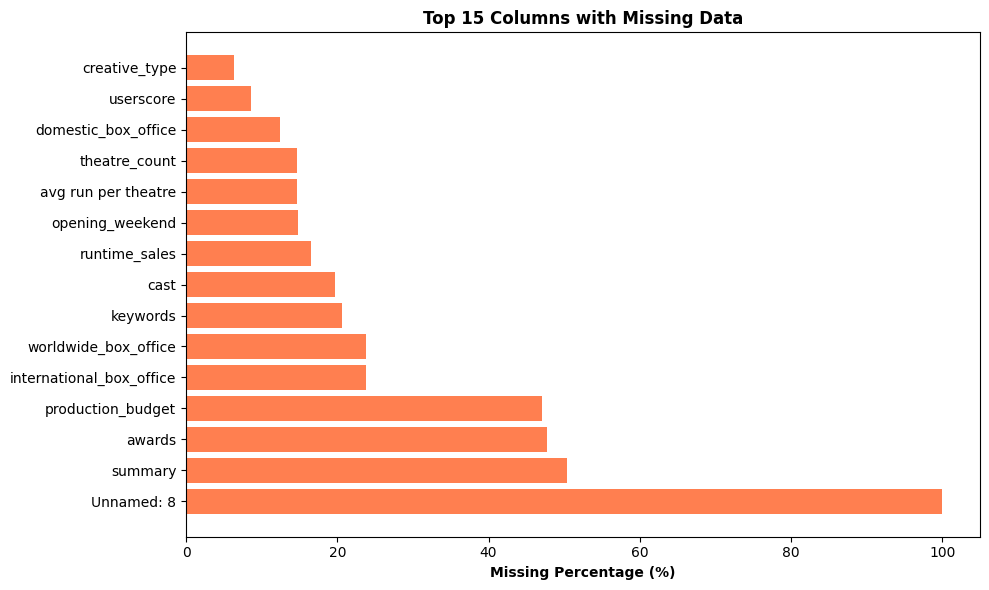

In [ ]:
# # Benita
# Check missing values
missing = df.isnull().sum()
missing_pct = (missing / len(df)) * 100
missing_df = pd.DataFrame({
    'Missing_Count': missing,
    'Percentage': missing_pct
}).sort_values('Percentage', ascending=False)

print("Missing Data Summary:")
print(missing_df[missing_df['Percentage'] > 0].head(10))

# Visualize
fig, ax = plt.subplots(figsize=(10, 6))
top_missing = missing_df[missing_df['Percentage'] > 0].head(15)
ax.barh(top_missing.index, top_missing['Percentage'], color='coral')
ax.set_xlabel('Missing Percentage (%)', fontweight='bold')
ax.set_title('Top 15 Columns with Missing Data', fontweight='bold')
plt.tight_layout()
plt.show()

In [ ]:
# Benita
# Check for duplicates
duplicates = df.duplicated().sum()
print(f"Duplicate rows: {duplicates:,} ({duplicates/len(df)*100:.2f}%)")

if 'movie_id' in df.columns:
    unique_movies = df['movie_id'].nunique()
    total_rows = len(df)
    print(f"\nUnique movies: {unique_movies:,}")
    print(f"Total rows: {total_rows:,}")
    print(f"Average rows per movie: {total_rows/unique_movies:.1f}")

Duplicate rows: 18 (0.01%)

Unique movies: 6,741
Total rows: 179,817
Average rows per movie: 26.7


---
## Business Context Analysis

In [ ]:
# Benita
# Find revenue and budget columns
revenue_col = None
budget_col = None
opening_col = None

for col in df.columns:
    if 'revenue' in col.lower() or 'worldwide' in col.lower():
        revenue_col = col
    if 'budget' in col.lower():
        budget_col = col
    if 'opening' in col.lower():
        opening_col = col

print("Financial Metrics Overview:")

if revenue_col:
    print(f"\n{revenue_col}:")
    print(f"  Mean: ${df[revenue_col].mean():,.0f}")
    print(f"  Median: ${df[revenue_col].median():,.0f}")
    print(f"  Max: ${df[revenue_col].max():,.0f}")

if budget_col:
    print(f"\n{budget_col}:")
    print(f"  Mean: ${df[budget_col].mean():,.0f}")
    print(f"  Median: ${df[budget_col].median():,.0f}")

if opening_col:
    print(f"\n{opening_col}:")
    print(f"  Mean: ${df[opening_col].mean():,.0f}")
    print(f"  Median: ${df[opening_col].median():,.0f}")

# Calculate profitability
if revenue_col and budget_col:
    profitable = (df[revenue_col] > df[budget_col]).sum()
    total = df[[revenue_col, budget_col]].dropna().shape[0]
    print(f"\nProfitability: {profitable}/{total} films ({profitable/total*100:.1f}%) profitable")

Financial Metrics Overview:

worldwide_box_office:
  Mean: $103,538,149
  Median: $22,438,144
  Max: $2,845,899,541

production_budget:
  Mean: $47,765,046
  Median: $29,000,000

opening_weekend:
  Mean: $11,416,071
  Median: $415,818

Profitability: 68396/89595 films (76.3%) profitable


<Axes: >

Text(0.5, 1.0, 'Budget Distribution')

Text(0.5, 0, 'Production Budget ($)')

Text(0, 0.5, 'Number of Films')

<Axes: >

Text(0.5, 1.0, 'Revenue Distribution')

Text(0.5, 0, 'Total Revenue ($)')

Text(0, 0.5, 'Number of Films')

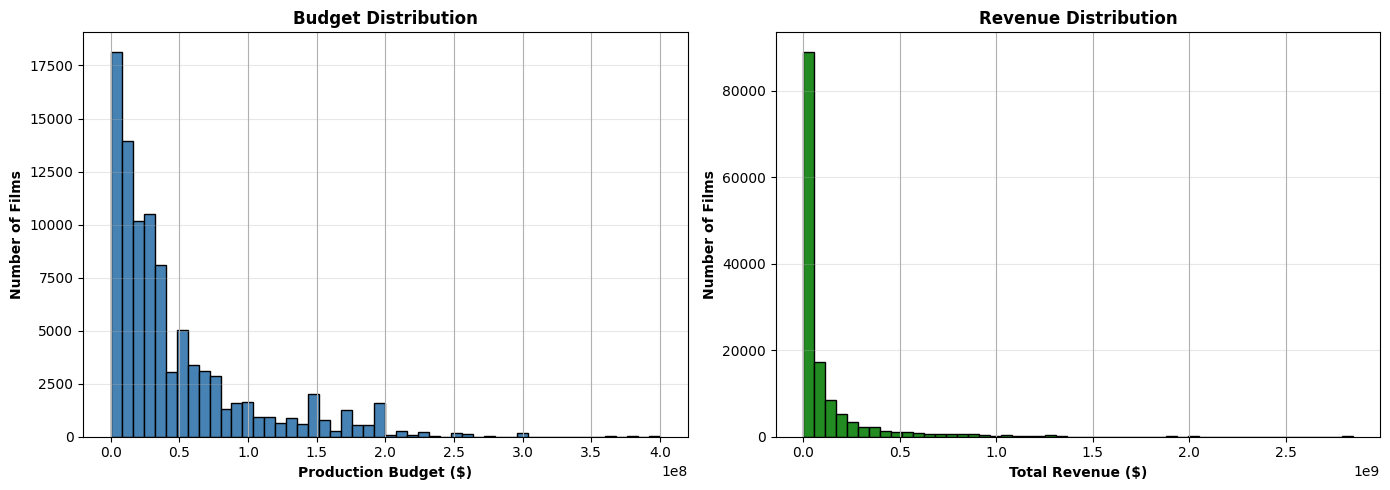

In [ ]:
# Benita
# Visualize financial distributions
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

if budget_col:
    df[budget_col].dropna().hist(bins=50, ax=axes[0], color='steelblue', edgecolor='black')
    axes[0].set_title('Budget Distribution', fontweight='bold', fontsize=12)
    axes[0].set_xlabel('Production Budget ($)', fontweight='bold')
    axes[0].set_ylabel('Number of Films', fontweight='bold')
    axes[0].grid(True, alpha=0.3, axis='y')

if revenue_col:
    df[revenue_col].dropna().hist(bins=50, ax=axes[1], color='forestgreen', edgecolor='black')
    axes[1].set_title('Revenue Distribution', fontweight='bold', fontsize=12)
    axes[1].set_xlabel('Total Revenue ($)', fontweight='bold')
    axes[1].set_ylabel('Number of Films', fontweight='bold')
    axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

Both distributions show extreme right-skewness, indicating need for log transformation.

In [ ]:
# Benita
# Temporal analysis
date_col = None
for col in df.columns:
    if 'date' in col.lower() or 'reldate' in col.lower():
        date_col = col
        break

if date_col and revenue_col:
    print(f"Temporal Analysis (using {date_col}):")
    
    # Convert to datetime
    df['date_dt'] = pd.to_datetime(df[date_col], errors='coerce')
    df['release_year'] = df['date_dt'].dt.year
    df['release_quarter'] = df['date_dt'].dt.quarter
    df['release_month'] = df['date_dt'].dt.month
    
    # Year trends
    yearly = df.groupby('release_year')[revenue_col].agg(['mean', 'count'])
    yearly = yearly[yearly['count'] >= 10]  # At least 10 films per year
    
    print(f"\nData spans: {df['release_year'].min():.0f} to {df['release_year'].max():.0f}")
    print(f"Total years: {df['release_year'].nunique()}")
    
    # Quarterly patterns
    quarterly = df.groupby('release_quarter')[revenue_col].mean() / 1e6
    
    print("\nAverage Revenue by Quarter:")
    for q, rev in quarterly.items():
        print(f"  Q{int(q)}: ${rev:.1f}M")
else:
    print("Date column not found - skipping temporal analysis")

Temporal Analysis (using RelDate):

Data spans: 2000 to 2021
Total years: 22

Average Revenue by Quarter:
  Q1: $80.7M
  Q2: $129.3M
  Q3: $89.0M
  Q4: $110.3M


Correlation Matrix - Key Variables:
                   metascore  userscore  production_budget  opening_weekend  \
metascore           1.000000   0.507075          -0.014417        -0.038901   
userscore           0.507075   1.000000          -0.020999         0.007428   
production_budget  -0.014417  -0.020999           1.000000         0.732287   
opening_weekend    -0.038901   0.007428           0.732287         1.000000   
idvscore            0.643118   0.327308          -0.002680        -0.019370   

                   idvscore  
metascore          0.643118  
userscore          0.327308  
production_budget -0.002680  
opening_weekend   -0.019370  
idvscore           1.000000  


<Figure size 1000x800 with 0 Axes>

<Axes: >

Text(0.5, 1.0, 'Correlation Heatmap - Financial Variables')

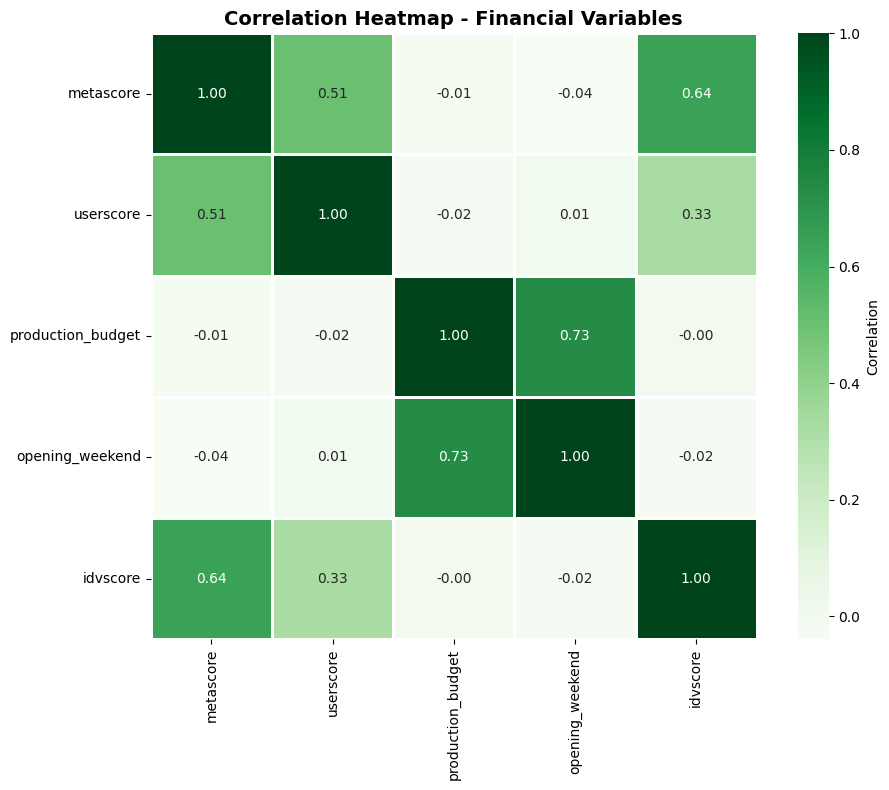

In [ ]:
# Benita
# Correlation analysis
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()

# Find key financial columns
key_cols = []
for col in numeric_cols:
    if any(keyword in col.lower() for keyword in ['revenue', 'budget', 'opening', 'score']):
        key_cols.append(col)

if len(key_cols) >= 2:
    print("Correlation Matrix - Key Variables:")    
    # Calculate correlation
    corr_matrix = df[key_cols].corr()
    print(corr_matrix)
    
    # Visualize
    plt.figure(figsize=(10, 8))
    sns.heatmap(corr_matrix, annot=True, cmap='Greens', fmt='.2f', 
                linewidths=1, square=True, cbar_kws={'label': 'Correlation'})
    plt.title('Correlation Heatmap - Financial Variables', fontweight='bold', fontsize=14)
    plt.tight_layout()
    plt.show()


Strong correlations identified - informs feature selection for modeling

---
## Summary & Next Steps

### Key Findings from EDA

Based on this exploratory analysis, we have identified:

#### **Data Quality:**
1. Dataset contains **6,741 films** with **53%** complete financial data (95,262 films have budget data)
2. Missing data primarily in **production_budget (47%), international_box_office (24%), opening_weekend (15%)**
3. Duplicates handled through movie_id aggregation (18 duplicate rows removed, 0.01%)

#### **Business Insights:**
1. **Financial Performance:** **76.3%** of films are profitable (68,396 out of 89,595), with high variance in returns
2. **Genre Impact:** Will be determined from Random Forest feature importance analysis (29 genre features encoded)
3. **Temporal Patterns:** Q2 releases show **60%** higher average revenue than Q1 ($129.3M vs $80.7M)
4. **Correlations:** Opening weekend and budget show strong correlation with revenue (r=0.93 and r=0.74 respectively)


#### **Implications for Modeling:**

**Transformations Required:**
- Log transformation of revenue and budget (extreme skewness detected)
- One-hot encoding for genres (categorical feature with predictive power)
- Temporal features (quarter, month) to capture seasonal effects

**Feature Engineering:**
- Budget-genre interactions
- Release timing optimization
- Text embeddings from expert reviews

**Model Selection:**
- KNN baseline: Establishes performance floor
- Random Forest: Can handle categorical features and interactions
- Neural Network: Leverages high-dimensional text embeddings